# Train Caption-ja letter classifier

Goal: **Classify letters into digits, :, /, ~ and others**

Let relevant letters = `{0-9, :, /, ~}`

Steps


1. Remove background from all input data

2. Get the maximum size of relevant letters -> `(nr, nc)`

3. filter out the data with size larger than `(nr+4, nc+4)`

4. Pad all remaing data to the size `(nr+4, nc+4)`

5. Train classification model on the created data
  
  A. One-step classifier
  
  B. Two-step classifer
  
    - Binary classification between relevant vs not
  
    - Multiclass classification among relevant letters

In [451]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator

In [415]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/caption/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(datadir): 
    print('data directory not found', os.path.abspath(datadir))
    raise
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

In [416]:
module_path = os.path.join(proj_root, 'kgschart')
sys.path.append(module_path)
from utils import pad_image

In [417]:
X = np.load(os.path.join(datadir, 'X-ja.npy'))
Y = np.load(os.path.join(datadir, 'Y-ja.npy'))

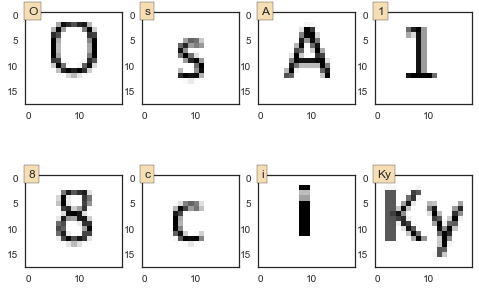

In [418]:
# convenient functions
def random_plot(X, Y, predicted=None):
    sns.set_style('white')
    indices = np.random.choice(len(Y), min(8, len(Y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        text = Y[i] if predicted is None else 'tr: %s, pr: %s' % (Y[i], predicted[i])
        ax.text(0, 0, text, bbox={'facecolor':"wheat"})
    plt.show(block=False)

random_plot(X, Y)


def compare_plot(X1, X2):
    sns.set_style('white')
    indices = range(3) if len(X1) <= 3 else np.random.choice(len(X1), 3)
    count = 0
    for i in indices:
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X1[i], cmap='gray')
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X2[i], cmap='gray')
    plt.show(block=False)

def generate_augmented_data(X, Y, target_size, seed=None):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.1)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y


def diagnosis(fit, X, Y):
    print('accuracy = ', fit.score(X, Y))
    pred = fit.predict(X)
    wrong = (Y != pred)
    if np.any(wrong):
        random_plot(X[wrong], Y[wrong], pred[wrong])
    #print(classification_report(Y, pred))
    print(pd.crosstab(pd.Series(Y), pd.Series(pred), margins=True))



## Step 1 Remove background from all input data

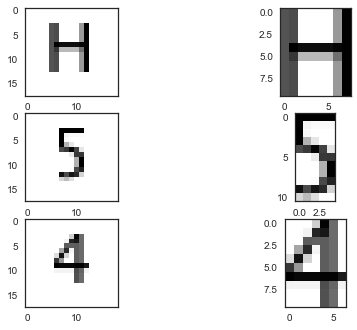

In [419]:
def remove_background(x, bg = 1.0):
    """
    from a image array of size (nrow, ncol),
    remove all rows and cols where values are all bg
    """
    not_bg = (x != bg)
    non_bg_rows = np.any(not_bg, axis=1)
    non_bg_cols = np.any(not_bg, axis=0)
    
    tmp = non_bg_rows.nonzero()[0]
    if len(tmp) == 0: return None
    i1 = tmp[0]
    i2 = tmp[-1] + 1
    
    tmp = non_bg_cols.nonzero()[0]
    if len(tmp) == 0: return None
    j1 = tmp[0]
    j2 = tmp[-1] + 1
    
    return x[i1:i2, j1:j2]

X_nobg = [remove_background(x) for x in X]
compare_plot(X, X_nobg)

## Step 2 Get the maximum size of relevant letters -> (nr, nc)

In [420]:
max_rows = 0
max_cols = 0

relevant_letters = [s for s in '0123456789/:?']
for i in range(len(Y)):
    if Y[i] in relevant_letters:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

13 7


## Step 3 filter out the data with size larger than (nr+4, nc+4)

target shape = (17, 11)
total: 109, included: 105, out: 4
non-included samples


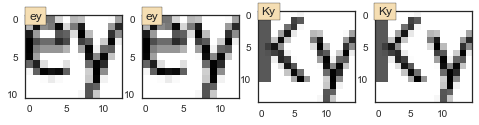

included samples


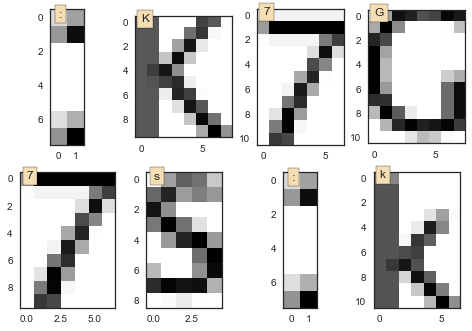

In [421]:
target_shape = (max_rows+4, max_cols+4)
print("target shape =", target_shape)
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)


## Step 4 Pad all remaing data to the size (nr+4, nc+4)

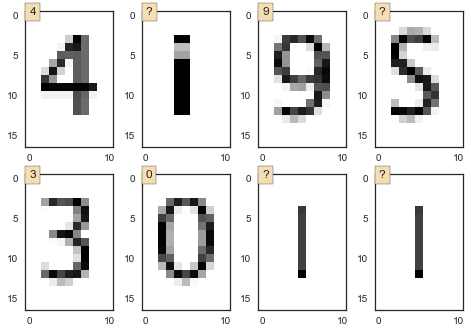

?    69
5     5
6     3
4     3
9     3
2     3
1     3
/     3
7     3
3     3
0     3
8     2
:     2
dtype: int64

In [422]:
X_in = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X_in]
X_in = [np.expand_dims(x, axis=0) for x in X_in]
X_in = np.vstack(X_in)

Y_in_true = np.array(Y_in)
Y_in = [y if y in relevant_letters else '?' for y in Y_in]
Y_in = np.array(Y_in)

random_plot(X_in, Y_in)
pd.Series(Y_in).value_counts()

## Step 5 Train classification model

In [423]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X_in, Y_in, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X_in, Y_in, 5000, seed = 7)

accuracy on original set =  0.914285714286
accuracy =  0.914285714286


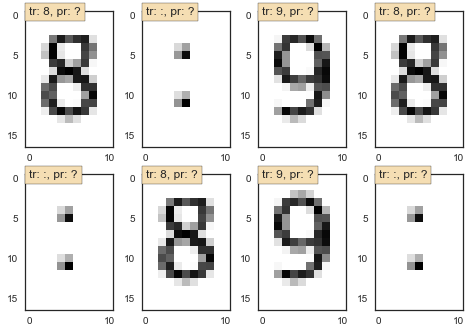

col_0  /  0  1  2  3  4  5  6  7   ?  All
row_0                                    
/      3  0  0  0  0  0  0  0  0   0    3
0      0  3  0  0  0  0  0  0  0   0    3
1      0  0  3  0  0  0  0  0  0   0    3
2      0  0  0  3  0  0  0  0  0   0    3
3      0  0  0  0  3  0  0  0  0   0    3
4      0  0  0  0  0  3  0  0  0   0    3
5      0  0  0  0  0  0  5  0  0   0    5
6      0  0  0  0  0  0  0  3  0   0    3
7      0  0  0  0  0  0  0  0  3   0    3
8      0  0  0  0  0  0  0  0  0   2    2
9      0  0  0  0  0  0  0  0  0   3    3
:      0  0  0  0  0  0  0  0  0   2    2
?      0  0  0  1  0  0  1  0  0  67   69
All    3  3  3  4  3  3  6  3  3  74  105
accuracy =  0.806035774958


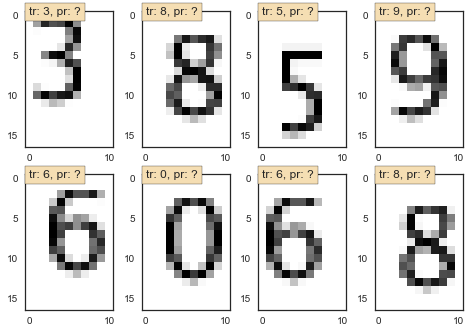

col_0    /    0    1    2    3    4    5   6    7   9     ?    All
row_0                                                             
/      198    0    0    0    0    0    0   0    0   0    88    286
0        0  112    0    0    0    0    0   0    0   0   175    287
1        0    0  106    0    0    0    0   0    0   0   180    286
2        0    0    0  193    0    0    0   0    0   0    94    287
3        0    0    0    0  152    0    0   0    0   0   133    285
4        0    0    0    0    0  154    0   0    0   0   132    286
5        0    0    0    0    0    0  370   0    0   0   107    477
6        0    0    0    0    0    0    0  89    0   0   197    286
7        0    0    0   23    0    0    0   0  189   0    73    285
8        0    0    0    0    0    0    0   0    0   0   190    190
9        0    0    0    0    0    0    0   0    0  58   228    286
:        0    0    0    0    0    0    0   0    0   0   190    190
?        0    0    0   50    0    0   80   0    1   0  6445   

In [424]:
# benchmark fit with support vector machine

# used for data preprocess
class Flatten:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}

    
pipe_svm = Pipeline([
    ('flatten', Flatten()), ('SVM', SVC())
])    
pipe_svm.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_svm.score(X_in, Y_in))
diagnosis(pipe_svm, X_in, Y_in)
diagnosis(pipe_svm, X_test, Y_test)

In [425]:
pipe_svm.classes_

array(['/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?'], 
      dtype='<U1')

SVM is not so bad! Just a naive fit achieves 80% accuracy!

### Consider Dimensionality reduction with PCA

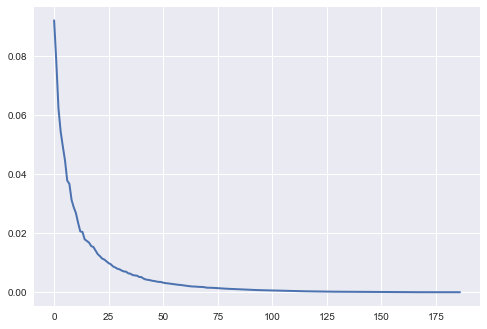

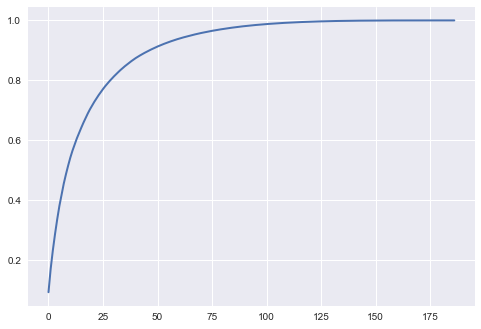

1 0.0919845896003
2 0.170014808089
3 0.232161870298
4 0.286532549442
5 0.335820478888
6 0.380363710189
7 0.418155999135
8 0.454800000546
9 0.486029070867
10 0.514755454056
11 0.54152044802
12 0.564966900914
13 0.585530150548
14 0.605929768564
15 0.623830884
16 0.641203422363
17 0.658001840316
18 0.673604707512
19 0.688911294758
20 0.703004768904
21 0.715880084054
22 0.728076139441
23 0.739464102616
24 0.750515461851
25 0.760957691217
26 0.770795168029
27 0.780241665348
28 0.788963242561
29 0.797343932676
30 0.80528139722
31 0.813022255111
32 0.82033633473
33 0.827365187108
34 0.834294155162
35 0.84067797574
36 0.846936547855
37 0.852740790815
38 0.858422169104
39 0.864019337064
40 0.869182755726
41 0.874290010889
42 0.878893214756
43 0.883200702658
44 0.887380731814
45 0.891447368985
46 0.895305953298
47 0.899087068445
48 0.902681469346
49 0.906173759315
50 0.909620797881
51 0.912843055931
52 0.915933562405
53 0.91894470535
54 0.92185447424
55 0.924662587005
56 0.927332842207
57 0.9299

In [426]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])

Maybe 100?

### Fit MLP

accuracy on original set =  0.990476190476
accuracy =  0.992805036474


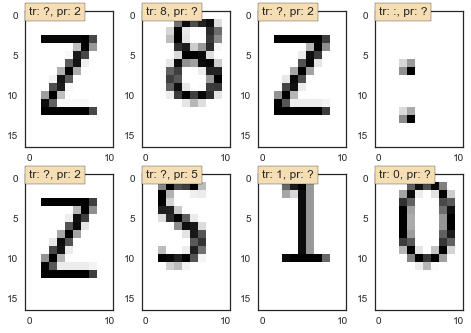

col_0    /    0    1    2    3    4    5    6    7    8    9    :     ?    All
row_0                                                                         
/      285    0    0    0    0    0    0    0    0    0    0    1     0    286
0        0  284    0    0    0    0    0    0    0    0    0    0     3    287
1        0    0  285    0    0    0    0    0    0    0    0    0     1    286
2        0    0    0  286    1    0    0    0    0    0    0    0     0    287
3        0    0    1    0  283    0    0    0    0    0    0    0     1    285
4        0    0    0    0    0  286    0    0    0    0    0    0     0    286
5        0    0    0    0    0    0  477    0    0    0    0    0     0    477
6        0    0    0    0    0    0    0  283    0    0    0    0     3    286
7        0    0    0    0    0    0    0    0  284    0    0    1     0    285
8        0    0    0    0    0    0    0    0    0  181    0    0     9    190
9        0    0    0    0    0    0    0    0    0  

In [427]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X_in, Y_in))
diagnosis(pipe_mlp, X_test, Y_test)

MLP is just amazing... We already have 99% accuracy...

#### Grid search for finding good configuration

In [428]:
pipe_grid = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
]) 
ncomp_options = [75, 100, 125]
alpha_options = [0.0001, 0.001, 0.01, 0.1]
layer_options = [(100,), (100,100), (100,100,100)]
param_grid = dict(
    PCA__n_components=ncomp_options,
    MLP__alpha=alpha_options,
    MLP__hidden_layer_sizes=layer_options
)

grid_savename = os.path.join(arcdir, 'caption-ja_pca-mlp-grid_all.pkl')
if False:  # change to True to do grid search again
    grid = GridSearchCV(pipe_grid, param_grid, cv=5, n_jobs=2, verbose=5)
    grid.fit(X_train, Y_train)
    
    joblib.dump(grid, grid_savename)
else:
    grid = joblib.load(grid_savename)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75 
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75, score=0.994054, total=   7.8s
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75, score=0.988095, total=  10.5s
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75, score=0.993056, total=   8.5s
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=75, score=0.992056, total=   9.5s
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(10

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min


[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.0001, PCA__n_components=125, score=0.994995, total=  11.2s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75, score=0.994054, total=   6.9s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75, score=0.991071, total=   7.4s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75, score=0.995040, total=   6.9s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=75, score=0.988989, total=   4.7s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.0001, PCA__n_components=100 
[CV]  MLP__hidden_layer_siz

[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.001, PCA__n_components=125, score=0.991071, total=  13.6s
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.001, PCA__n_components=125, score=0.994048, total=  12.8s
[CV] MLP__hidden_layer_sizes=(100,), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.001, PCA__n_components=125, score=0.994042, total=  13.2s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100,), MLP__alpha=0.001, PCA__n_components=125, score=0.995996, total=  13.3s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=75 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=75, score=0.994054, total=   8.0s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.00

[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  5.1min


[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=100, score=0.988083, total=   7.1s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=100, score=0.995996, total=   8.6s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125, score=0.989098, total=   7.6s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125, score=0.989087, total=   9.5s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125, score=0.994048, total=   7.0s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.001, PCA__n_components=125 
[CV]  MLP__hidden_layer_s

[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=100, score=0.988095, total=  11.0s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=100, score=0.989076, total=   7.1s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=100, score=0.993056, total=  11.6s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=125, score=0.992071, total=   6.9s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.01, PCA__n_components=100, score=0.993994, total=  12.7s
[CV] MLP__hidden_layer_sizes=(100, 

[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=75, score=0.995996, total=  13.5s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100, score=0.993062, total=  15.3s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100, score=0.992063, total=  13.0s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100, score=0.994048, total=  13.3s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100 


[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 13.3min


[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100, score=0.991063, total=  12.3s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=100, score=0.993994, total=   9.7s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125, score=0.992071, total=  12.3s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125, score=0.990079, total=  14.6s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125, score=0.992063, total=  15.7s
[CV] MLP__hidden_layer_sizes=(100, 100), MLP__alpha=0.1, PCA__n_components=125 
[CV]  MLP__hidden_layer_sizes=(100, 100), MLP

[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed: 15.6min finished


In [429]:
odr = np.argsort(grid.cv_results_['mean_test_score'])
for i in reversed(odr):
    print("%0.4f (+/-%0.04f) for %r" % 
        (grid.cv_results_['mean_test_score'][i], 
         grid.cv_results_['std_test_score'][i] * 2, 
         grid.cv_results_['params'][i]))
print(grid.best_params_)

0.9938 (+/-0.0032) for {'MLP__hidden_layer_sizes': (100,), 'MLP__alpha': 0.001, 'PCA__n_components': 125}
0.9928 (+/-0.0029) for {'MLP__hidden_layer_sizes': (100,), 'MLP__alpha': 0.01, 'PCA__n_components': 125}
0.9928 (+/-0.0023) for {'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 0.1, 'PCA__n_components': 100}
0.9928 (+/-0.0034) for {'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 0.0001, 'PCA__n_components': 100}
0.9928 (+/-0.0034) for {'MLP__hidden_layer_sizes': (100, 100, 100), 'MLP__alpha': 0.1, 'PCA__n_components': 100}
0.9926 (+/-0.0054) for {'MLP__hidden_layer_sizes': (100, 100, 100), 'MLP__alpha': 0.1, 'PCA__n_components': 125}
0.9926 (+/-0.0036) for {'MLP__hidden_layer_sizes': (100,), 'MLP__alpha': 0.0001, 'PCA__n_components': 125}
0.9926 (+/-0.0034) for {'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 0.1, 'PCA__n_components': 125}
0.9926 (+/-0.0045) for {'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 0.0001, 'PCA__n_components': 75}
0.9926 (+/-0.0034) 

accuracy on original set =  0.990476190476
accuracy =  0.990476190476


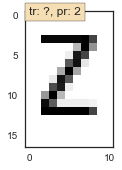

col_0  /  0  1  2  3  4  5  6  7  8  9  :   ?  All
row_0                                             
/      3  0  0  0  0  0  0  0  0  0  0  0   0    3
0      0  3  0  0  0  0  0  0  0  0  0  0   0    3
1      0  0  3  0  0  0  0  0  0  0  0  0   0    3
2      0  0  0  3  0  0  0  0  0  0  0  0   0    3
3      0  0  0  0  3  0  0  0  0  0  0  0   0    3
4      0  0  0  0  0  3  0  0  0  0  0  0   0    3
5      0  0  0  0  0  0  5  0  0  0  0  0   0    5
6      0  0  0  0  0  0  0  3  0  0  0  0   0    3
7      0  0  0  0  0  0  0  0  3  0  0  0   0    3
8      0  0  0  0  0  0  0  0  0  2  0  0   0    2
9      0  0  0  0  0  0  0  0  0  0  3  0   0    3
:      0  0  0  0  0  0  0  0  0  0  0  2   0    2
?      0  0  0  1  0  0  0  0  0  0  0  0  68   69
All    3  3  3  4  3  3  5  3  3  2  3  2  68  105
accuracy =  0.993904267013


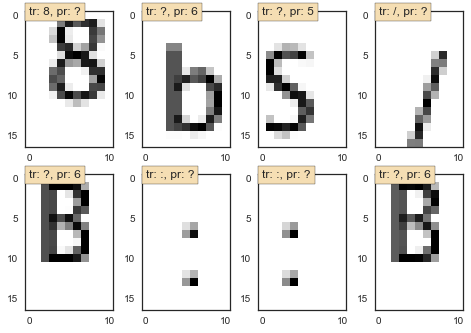

col_0    /    0    1    2    3    4    5    6    7    8    9    :     ?    All
row_0                                                                         
/      284    0    0    0    0    0    0    0    0    0    0    0     2    286
0        0  284    0    0    0    0    0    0    0    0    0    0     3    287
1        0    0  285    0    0    0    0    0    0    0    0    0     1    286
2        0    0    0  286    0    0    1    0    0    0    0    0     0    287
3        0    0    0    0  283    0    0    0    0    0    0    0     2    285
4        0    0    0    0    0  286    0    0    0    0    0    0     0    286
5        0    0    0    0    0    0  477    0    0    0    0    0     0    477
6        0    0    0    0    0    0    0  283    0    0    0    0     3    286
7        0    0    0    0    0    0    0    0  284    0    1    0     0    285
8        0    0    0    0    0    0    0    0    0  181    0    0     9    190
9        0    0    0    0    0    0    0    0    0  

In [430]:
print('accuracy on original set = ', grid.score(X_in, Y_in))

diagnosis(grid, X_in, Y_in)
diagnosis(grid, X_test, Y_test)

In [431]:
savename = os.path.join(modeldir, 'caption_pca-mlp-gridbest.pkl')

pipe = Pipeline([
    ('PCA', grid.best_estimator_.named_steps['PCA']),
    ('MLP', grid.best_estimator_.named_steps['MLP'])
])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption_pca-mlp-gridbest.pkl']

#### Exhaustive training until perfect accuracy

In [432]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=125)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = grid.best_estimator_.classes_

train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X_in, Y_in, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X_in, Y_in)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1009 score on test = 0.6473468572 score on original = 0.657142857143
101909 score on test = 0.989007694614 score on original = 0.990476190476
202809 score on test = 0.993404616768 score on original = 1.0
303709 score on test = 0.997601678825 score on original = 1.0
404609 score on test = 0.997301888678 score on original = 1.0
505509 score on test = 0.998201259119 score on original = 1.0
606409 score on test = 0.998800839412 score on original = 1.0
707309 score on test = 0.99900069951 score on original = 1.0
808209 score on test = 0.997801538923 score on original = 1.0
909109 score on test = 0.999400419706 score on original = 1.0
1010009 score on test = 0.999600279804 score on original = 1.0
1110909 score on test = 0.999600279804 score on original = 1.0
1211809 score on test = 0.998900769461 score on original = 1.0
1312709 score on test = 0.999600279804 score on original = 1.0
1413609 score on test = 0.999700209853 score on original = 1.0
DONE!


In [433]:
diagnosis(pipe_pred, X_in, Y_in)
diagnosis(pipe_pred, X_test, Y_test)

accuracy =  1.0
col_0  /  0  1  2  3  4  5  6  7  8  9  :   ?  All
row_0                                             
/      3  0  0  0  0  0  0  0  0  0  0  0   0    3
0      0  3  0  0  0  0  0  0  0  0  0  0   0    3
1      0  0  3  0  0  0  0  0  0  0  0  0   0    3
2      0  0  0  3  0  0  0  0  0  0  0  0   0    3
3      0  0  0  0  3  0  0  0  0  0  0  0   0    3
4      0  0  0  0  0  3  0  0  0  0  0  0   0    3
5      0  0  0  0  0  0  5  0  0  0  0  0   0    5
6      0  0  0  0  0  0  0  3  0  0  0  0   0    3
7      0  0  0  0  0  0  0  0  3  0  0  0   0    3
8      0  0  0  0  0  0  0  0  0  2  0  0   0    2
9      0  0  0  0  0  0  0  0  0  0  3  0   0    3
:      0  0  0  0  0  0  0  0  0  0  0  2   0    2
?      0  0  0  0  0  0  0  0  0  0  0  0  69   69
All    3  3  3  3  3  3  5  3  3  2  3  2  69  105
accuracy =  1.0
col_0    /    0    1    2    3    4    5    6    7    8    9    :     ?    All
row_0                                                                    

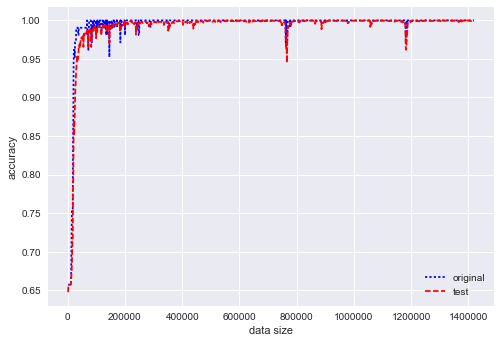

In [434]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [435]:
# save PCA-MLP part
savename = os.path.join(modeldir, 'caption-ja_pca-mlp-full.pkl')
pipe = ([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption-ja_pca-mlp-full.pkl']

This model looks reasonable!  This would be our first choice.

### Two step classification

#### Classify relevant vs not

In [436]:
Y_in1 = (Y_in != '?') 

# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X_in, Y_in1, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X_in, Y_in1, 5000, seed = 7)

**Logistic regression**

accuracy =  0.815629059658


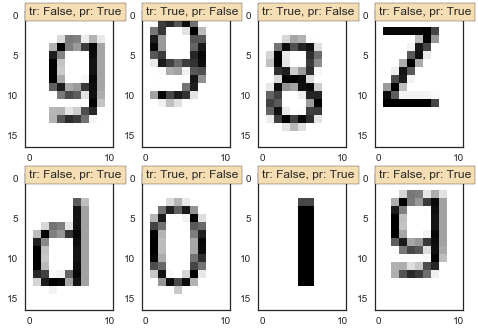

col_0  False  True    All
row_0                    
False   5807   769   6576
True    1076  2355   3431
All     6883  3124  10007
accuracy =  0.895238095238


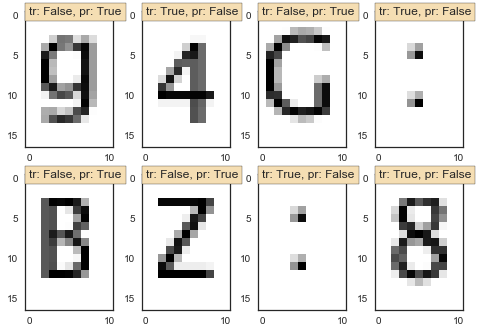

col_0  False  True  All
row_0                  
False     62     7   69
True       4    32   36
All       66    39  105


In [437]:
pipe = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('Logit', LogisticRegression(penalty='l1'))
])
pipe.fit(X_train, Y_train)

diagnosis(pipe, X_test, Y_test)
diagnosis(pipe, X_in, Y_in1)

**MLP**

accuracy =  0.993304686719


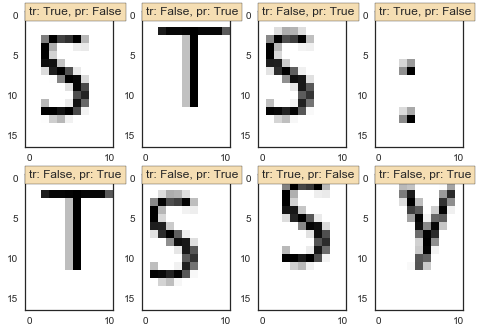

col_0  False  True    All
row_0                    
False   6537    39   6576
True      28  3403   3431
All     6565  3442  10007
accuracy =  0.990476190476


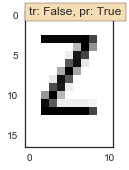

col_0  False  True  All
row_0                  
False     68     1   69
True       0    36   36
All       68    37  105


In [438]:
pipe = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.001))
])
pipe.fit(X_train, Y_train)



diagnosis(pipe, X_test, Y_test)
diagnosis(pipe, X_in, Y_in1)

**Exhaustive traiging**

In [439]:
classes = pipe.named_steps['MLP'].classes_

In [440]:
np.random.seed(87)


# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=125)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])


train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X_in, Y_in1, 500)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X_in, Y_in1)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

516 score on test = 0.64634755671 score on original = 0.619047619048
52116 score on test = 0.993104826621 score on original = 1.0
103716 score on test = 0.999200559608 score on original = 1.0
155316 score on test = 0.998600979314 score on original = 1.0
206916 score on test = 0.99810132907 score on original = 1.0
258516 score on test = 0.998800839412 score on original = 1.0
310116 score on test = 0.999700209853 score on original = 1.0
361716 score on test = 0.999400419706 score on original = 1.0
413316 score on test = 0.999700209853 score on original = 1.0
DONE!


In [441]:
diagnosis(pipe_pred, X_in, Y_in1)
diagnosis(pipe_pred, X_test, Y_test)

accuracy =  1.0
col_0  False  True  All
row_0                  
False     69     0   69
True       0    36   36
All       69    36  105
accuracy =  1.0
col_0  False  True    All
row_0                    
False   6576     0   6576
True       0  3431   3431
All     6576  3431  10007


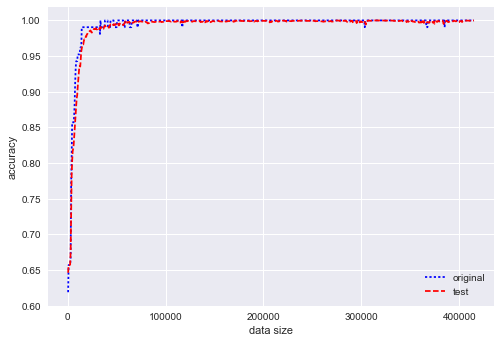

In [442]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [443]:
savename = os.path.join(modeldir, 'caption-ja_pca-mlp-step1-full.pkl')
pipe = ([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption-ja_pca-mlp-step1-full.pkl']

#### Classification among relevant letters

In [444]:
X_in2 = X_in[Y_in != '?']
Y_in2 = Y_in[Y_in != '?']

pd.Series(Y_in2).value_counts()

# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X_in2, Y_in2, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X_in2, Y_in2, 5000, seed = 7)

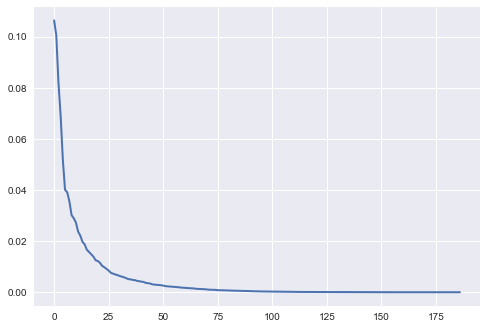

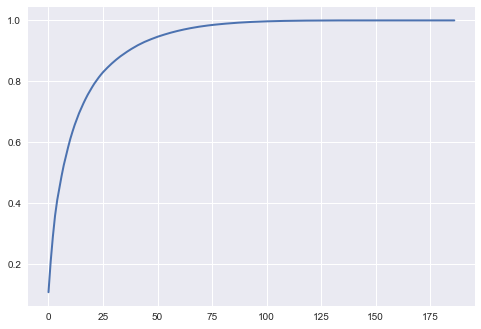

1 0.106337789764
2 0.206785193527
3 0.288621481792
4 0.357563263082
5 0.409406179982
6 0.449500613026
7 0.488588549139
8 0.524127327354
9 0.554288814738
10 0.583226291247
11 0.610458775554
12 0.634168548935
13 0.65629153228
14 0.67599837304
15 0.694713071329
16 0.711334256613
17 0.727086410273
18 0.74191893188
19 0.755852644277
20 0.768376816794
21 0.780586328644
22 0.792100025615
23 0.802413652023
24 0.812195713006
25 0.821323224678
26 0.829794077768
27 0.837384590521
28 0.844640851916
29 0.851592014113
30 0.858305055803
31 0.864658873374
32 0.870747364715
33 0.876603567517
34 0.882075566642
35 0.887205535703
36 0.892228055524
37 0.897044228978
38 0.901766374562
39 0.906200125707
40 0.910471933391
41 0.914622849818
42 0.918629828298
43 0.922285740068
44 0.92582918072
45 0.929228716203
46 0.932306679095
47 0.935286071956
48 0.938164506072
49 0.941000507178
50 0.943742511938
51 0.946298564089
52 0.948707575119
53 0.950989302419
54 0.953224379163
55 0.955386008129
56 0.957476892371
57 0.

In [445]:
pipe_pca = Pipeline([('flatten', Flatten()), ('PCA', PCA())]) 
pipe_pca.fit(X_train)

sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])

100 or 80?

In [446]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), ('PCA', PCA(n_components=80)), ('MLP', MLPClassifier())
]) 
pipe_mlp.fit(X_train, Y_train)
diagnosis(pipe_mlp, X_test, Y_test)
diagnosis(pipe_mlp, X_in2, Y_in2)

classes = pipe_mlp.named_steps['MLP'].classes_
classes

accuracy =  1.0
col_0    /    0    1    2    3    4     5    6    7    8    9    :    All
row_0                                                                    
/      834    0    0    0    0    0     0    0    0    0    0    0    834
0        0  834    0    0    0    0     0    0    0    0    0    0    834
1        0    0  833    0    0    0     0    0    0    0    0    0    833
2        0    0    0  834    0    0     0    0    0    0    0    0    834
3        0    0    0    0  834    0     0    0    0    0    0    0    834
4        0    0    0    0    0  834     0    0    0    0    0    0    834
5        0    0    0    0    0    0  1390    0    0    0    0    0   1390
6        0    0    0    0    0    0     0  833    0    0    0    0    833
7        0    0    0    0    0    0     0    0  834    0    0    0    834
8        0    0    0    0    0    0     0    0    0  555    0    0    555
9        0    0    0    0    0    0     0    0    0    0  834    0    834
:        0    0    0  

array(['/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':'], 
      dtype='<U1')

In [447]:
np.random.seed(87)


# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=80)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])


train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X_in2, Y_in2, 500)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X_in2, Y_in2)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

500 score on test = 0.196721311475 score on original = 0.111111111111
DONE!


In [448]:
diagnosis(pipe_pred, X_in2, Y_in2)
diagnosis(pipe_pred, X_test, Y_test)

accuracy =  1.0
col_0  /  0  1  2  3  4  5  6  7  8  9  :  All
row_0                                         
/      3  0  0  0  0  0  0  0  0  0  0  0    3
0      0  3  0  0  0  0  0  0  0  0  0  0    3
1      0  0  3  0  0  0  0  0  0  0  0  0    3
2      0  0  0  3  0  0  0  0  0  0  0  0    3
3      0  0  0  0  3  0  0  0  0  0  0  0    3
4      0  0  0  0  0  3  0  0  0  0  0  0    3
5      0  0  0  0  0  0  5  0  0  0  0  0    5
6      0  0  0  0  0  0  0  3  0  0  0  0    3
7      0  0  0  0  0  0  0  0  3  0  0  0    3
8      0  0  0  0  0  0  0  0  0  2  0  0    2
9      0  0  0  0  0  0  0  0  0  0  3  0    3
:      0  0  0  0  0  0  0  0  0  0  0  2    2
All    3  3  3  3  3  3  5  3  3  2  3  2   36
accuracy =  1.0
col_0    /    0    1    2    3    4     5    6    7    8    9    :    All
row_0                                                                    
/      834    0    0    0    0    0     0    0    0    0    0    0    834
0        0  834    0    0    0    0     0

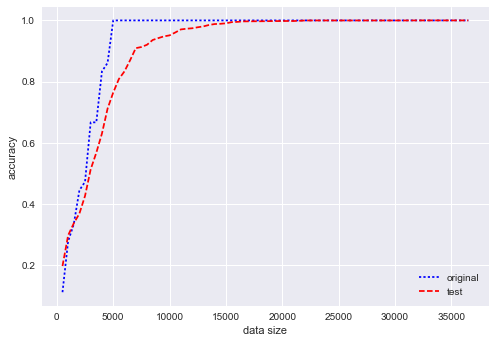

In [449]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [450]:
savename = os.path.join(modeldir, 'caption-ja_pca-mlp-step2-full.pkl')
pipe = ([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption-ja_pca-mlp-step2-full.pkl']

It seems that the second step (classification among relevant letters) is much easier than that first step (classification between relevant vs non-relevant letters).  I guess the main reason is similarity between `S` and `5`, `Z` and `2`, etc.  
Also, since we will have a lot more unseen letters in the practice, some care will be needed.
One idea is that, for example, if a letter is between two or three consecutive relevant letter, we assume the letter is also relevant.  With this type of aid to create consecutive relevant letters, the second step classification will not fail almost surely. 

Finally, save the input shape as the reference for later application.

In [454]:
with open(os.path.join(modeldir, 'caption-ja-config.json'), 'w') as file:
    json.dump(dict(input_shape=X_in.shape[1:]), file)